<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Reasoning/audio/beat_tracking_and_tempo_from_music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import librosa
librosa.show_versions()

INSTALLED VERSIONS
------------------
python: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

librosa: 0.8.1

audioread: 2.1.9
numpy: 1.21.6
scipy: 1.4.1
sklearn: 1.0.2
joblib: 1.1.0
decorator: 4.4.2
soundfile: 0.10.3
resampy: 0.2.2
numba: 0.51.2

numpydoc: None
sphinx: 1.8.6
sphinx_rtd_theme: None
sphinxcontrib.versioning: None
sphinx-gallery: None
pytest: 3.6.4
pytest-mpl: None
pytest-cov: None
matplotlib: 3.2.2
presets: None


In [ ]:
import matplotlib.pyplot as plt
from librosa import display
import numpy as np
import IPython

In [ ]:
filename = librosa.example('choice')

In [ ]:
IPython.display.Audio(filename)

**Loading Audio file**<hr>
loads and decodes the audio as a time series (frames_wave), sampling_rate (number of samples per second of audio)
By default, all audio is mixed to mono and resampled to 22050 Hz at load time. This behavior can be overridden by supplying additional

In [ ]:
frames_wave, sampling_rate = librosa.load(filename)
print("frames_wave:", frames_wave.shape, "sampling_rate:", sampling_rate)

frames_wave: (551823,) sampling_rate: 22050


In [ ]:
# tempo, frames_beats = librosa.beat.beat_track(y=frames_wave, sr=sampling_rate)
# print("tempo:", tempo, "\nframes_beats:", frames_beats)

## References
> https://asmp-eurasipjournals.springeropen.com/track/pdf/10.1186/s13636-021-00214-7.pdf

> https://www.youtube.com/watch?v=FmwpkdcAXl0

## Introduction

Beat tracking is the task of defining the points in time where a human listener would tap the beat if listening to a song.

**Beat**

> Sequence of equally spaced impulses, which periodically occur in
music. The perceptually most salient pulse (foot tapping rate)


**Tempo**
> The tempo of a piece is the inverse of the beat period. Instead of
frequency in Hz, we think beats per minute (BPM).


Both tempo and beats are fundamental property of a music

**Note onset**

> Musical note onsets can be simply defined as the start
of the notes and hence determine the temporal structure
of music. It can be formulated as an acoustic event detection problem with the signal under processing being a piece of music and the
events being the note onsets. <br>


> Eg.Tapping of foot in music

> <img src='https://raw.githubusercontent.com/pankajr141/experiments/master/images/audio_beattracking/another_one_bite.png' width=450>


> <img src='https://raw.githubusercontent.com/pankajr141/experiments/master/images/audio_beattracking/audio_note.png' width=250>


**challenges -** 
1. For string based music note onsets are soft, hence difficult to detect unlike hard drum beats.
2. in case of changing tempo its hard to detect
3. rhythmic displacements



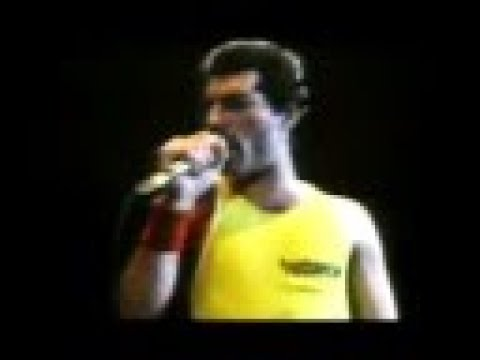

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('rY0WxgSXdEE', width=600, height=300)

**Note Onset Detection (NOD) methods**
> In literature, their are methids for of NOD **data-driven and non-data-driven**
methods. <br>
>> **Data driven** - methods build statistical models by using ML algos
on a large set of training data. For instance, learning a
probabilistic (hidden Markov) model exploiting the rhythmic regularity in music, training a neural network. These machine learning methods can either solve a classification problem, differentiating onsets from non-onsets, or a regression problem of which the output is then used
to estimate a suitable ODF( onset detection function )

>> **Non-Data driven** - methods, the ODF is directly calculated from the analyzed signal or its extracted features, they may operate in time or frequency domain and differ in the type of features extracted from the analyzed signal: magnitude, phase, energy, power spectral density, or time
derivatives of these.

state of art non-data-driven uses complex flux feature.

## Beat Track Detection (General Algorithm)

1. Measure onset strength <br>
<img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_1.png' width=250>
2. Tempo Estimation - from onset correlation <br>
<img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_2.png' width=250>
3. Pick peaks in onset strength approximately consistent with estimated tempo <br>
<img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_3.png' width=250>


## Measure onset strength 
> https://www.youtube.com/watch?v=FmwpkdcAXl0

**1. Spectogram (STFT)** <br>
> To detect node onset first step is to detect change in energy signature or frequency content, for that we apply STFT to convert signal into spectogram, below image describe magnitude of spectogram.

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_step1.png' width=450>

**2. Log compression** <br>
> Allow to adjust to dynamic range of the signal to enhance weaker spectral component specifically in high frequency range.

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_step2.png' width=450>

**3. Differentiation** <br>
> computing discreate derivative of above log compressed spectrum, in a row wise fashion for each frequency band separately. Only positive differeces are considered since we are interested in only energy increases.

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_step3.png' width=450>

**4. Accumalation** <br>
> All the positive differency obtained above are summed in column wise fashion which yield a single positive number at each point in time. As a result a curve is obtained which is also known as novality curve.
The peak indicate time position where major changes happended in spectrum.

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_step4.png' width=450>

> We compute a local average curve which is then subracted from novelity curve

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_step5.png' width=450>

**5. Normalization** <br> Normalizing the novelity curve, peaks of novelity curves are good candidates for node onsets, as they signify positive energy changes.

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_step6.png' width=450>

**6. clipping peaks** <br>
> Peaks of the novelty curve are note onset candidates, we can use thresholding to extract node onset. Peak-picking is a very fragile step in particular for soft onsets (strings)

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_step7.png' width=450>


summary - 

1. we calculated novelity curve to capture some signal properties like energy, spectrum
2. Energy based methods work for percussive music only
3. Peaks of the novelty curve indicate note onset candidates
4. Extraction of note onsets by peak-picking methods
(thresholding)

## Tempo Estimation

For tempo estimation we will make certain assumtion that in a certain time window beat occur in periodic fashion.

We are going to analyze the noveity curve for this periodic signals using
1. autocorrelation tempogram
2. Fourier Transform

**autocorrelation tempogram**<hr>

<i>Grosche, Peter, Meinard Müller, and Frank Kurth. “Cyclic tempogram - A mid-level tempo representation for music signals.” ICASSP, 2010.</i>

1. Here we compare novelity curve with time shifted copies of itself. 

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/temporal_step1.png' width=500>

2. We take a window and compute autocorrelation while moving the window across the signal. 

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/temporal_step2.png' width=900>

3. The values obtained by correlation is autocorrelation plot, the correlation plot will provide

> a. high values in for time lags where their is a high correlation<br>
> b. Regions which are self similar are revieled

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/temporal_step3.png' width=400>

4. convert time-lag into tempo (BPM)
> <pre> Tempo (in BPM ) = 60 / Lag (in sec) </pre>

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/temporal_step4.png' width=500>

5. Interpolate to a linear tempo axis in a musically meaningful tempo range

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/temporal_step5.png' width=400>


**Fourier tempogram**<hr>

1. pick a frame of novelity curve

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/fourier_step1.png' width=400>

2. Compute a single entry of tempogram by considering a suitable windows sinusoid of correponsing frequency and then it is correlated with section of novelity curve. <br>
Entry is defined by correlation value, in other words this value is magnitude of suitable fourier constant.

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/fourier_step2.png' width=400>

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/fourier_step3.png' width=400>
 
3. For each time position or column we consider the maximizing coefficient (Each such coefficient defines a windowed sinusoid of local periodicity kernel, which in turn explain the local periodic behaviour of novelity curve)

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/fourier_step4.png' width=400>


4. Accumulate all maximizing kernels over time, such as 1 kernel per frame. By above we will obtain a single curve

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/fourier_step5.png' width=400>

5. halfwave rectification - setting all -ve values to zero

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/fourier_step6.png' width=400>

6. **Predominant Local Pulse (PLP)** 

> Original novelity curve is noisy, having peaks which are small and blurred.
PLP curve is much more refined and also doesnt loose any original information, on the other hand it enhances certain peaks. It can recover weak onsets present in novelity curve. It captures sudden changes in local are meaning if in a music file is suddently tempo increases PLP will be able to capture that due to accumulation and local periodicity kernel.

> It can be regarded as periodicity enhancement of original novelity curve.

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/fourier_step7.png' width=400>

| Novelity curve | Predominant Local Pulse (PLP) curve |
| --- | --- |
| Indicates note onset candidates | Periodic enhancement of novelity curve |
| Extraction err in particular soft onsets | Accumulation introduce error robustness |
| Simple peak picking problem | Locality of kernels handles tempo variations |


6. **Predominant Local Pulse (PLP) - modification** 
> one can improve PLP by introducing prior knowledge, one can restrict the peridicity kernel periodicity in certain range for example the kernel with range 100-150 ppm will be allowed in our PLP. <br>
increase duration of kernel (windows)





In [ ]:
onset_env = librosa.onset.onset_strength(y=frames_wave, sr=sampling_rate, aggregate=np.median)
tempo, frames_beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sampling_rate)
print("tempo:", tempo, "\nframes_beats:", frames_beats)

tempo: 135.99917763157896 
frames_beats: [   3   21   40   59   78   96  116  135  154  173  192  211  230  249
  268  287  306  325  344  363  382  401  420  439  458  476  495  515
  534  553  572  591  610  629  647  667  686  705  724  743  762  780
  799  819  838  857  876  895  914  933  951  971  990 1008]


In [ ]:
librosa.frames_to_time(frames_beats, sr=sampling_rate)

array([ 0.06965986,  0.48761905,  0.92879819,  1.36997732,  1.81115646,
        2.22911565,  2.69351474,  3.13469388,  3.57587302,  4.01705215,
        4.45823129,  4.89941043,  5.34058957,  5.78176871,  6.22294785,
        6.66412698,  7.10530612,  7.54648526,  7.9876644 ,  8.42884354,
        8.87002268,  9.31120181,  9.75238095, 10.19356009, 10.63473923,
       11.05269841, 11.49387755, 11.95827664, 12.39945578, 12.84063492,
       13.28181406, 13.7229932 , 14.16417234, 14.60535147, 15.02331066,
       15.48770975, 15.92888889, 16.37006803, 16.81124717, 17.2524263 ,
       17.69360544, 18.11156463, 18.55274376, 19.01714286, 19.458322  ,
       19.89950113, 20.34068027, 20.78185941, 21.22303855, 21.66421769,
       22.08217687, 22.54657596, 22.9877551 , 23.40571429])

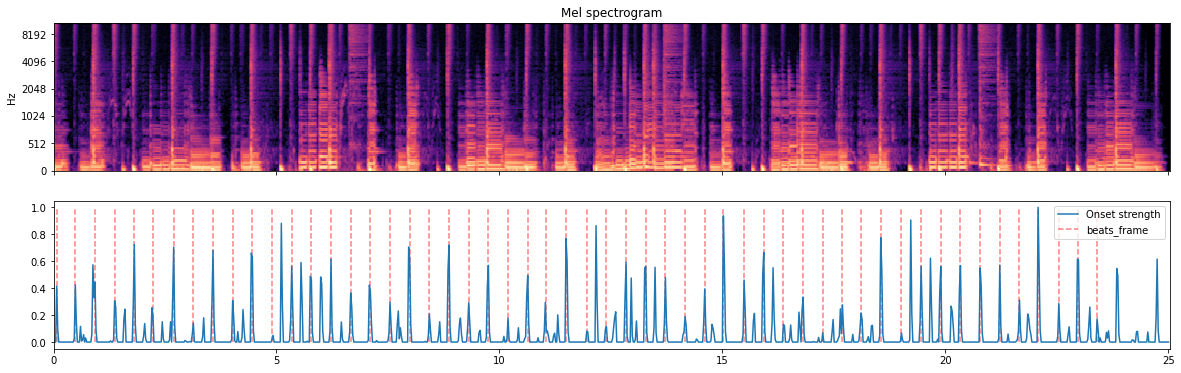

In [ ]:
hop_length = 512
figsize =(20, 6)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=figsize, dpi=72)

times = librosa.times_like(onset_env, sr=sampling_rate, hop_length=hop_length)
M = librosa.feature.melspectrogram(y=frames_wave, sr=sampling_rate, hop_length=hop_length)
librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                         y_axis='mel', x_axis='time', hop_length=hop_length,
                         ax=ax[0])

ax[0].label_outer()
ax[0].set(title='Mel spectrogram')
ax[1].plot(times, librosa.util.normalize(onset_env),
         label='Onset strength')
ax[1].vlines(times[frames_beats], 0, 1, alpha=0.5, color='r',
           linestyle='--', label='beats_frame')
ax[1].legend()